In [39]:
import pandas as pd
import regex as re
import numpy as np
import copy
import spacy
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.matcher import Matcher
from spacy.util import filter_spans
import re
import matplotlib.pyplot as plt
from collections import Counter
from scipy import spatial
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt


from DocumentWorking import Document
import sys, importlib

nlp = spacy.load("en_core_web_lg")

In [63]:
def getSpans(spaCyDoc): 
    #now we want to get spans on punctuation 
    spanList = []
    spanStart = 0 
    spanEnd = 0
    for token in spaCyDoc: 
        if token.is_punct: 
            currSpan = spaCyDoc[spanStart:spanEnd]
            spanList.append(currSpan)
            spanStart = spanEnd + 1
        spanEnd += 1
    return spanList

#this inList will be a list of spans 
#TODO: make function that adds noun vectors together and uses those. Also consider 
#how distance should be defined here 
def extractNouns(inList): 
    outList = []
    #get only nouns from the spans 
    for item in inList: 
        tokenList = []
        for token in item: 
            if token.pos_ == "NOUN": 
                tokenList.append(token)
        outList.append(tokenList)
    return outList

def getSumSentVecs(inList): 
    outList = []
    for innerList in inList: 
        outList.append(sum([item.vector for item in innerList]))
    return outList

def getVectorDist(inList): 
    outerList = []
    for i in inList: 
        innerList = []
        for j in inList:
            innerList.append(spatial.distance.cosine(i, j))
        outerList.append(innerList)
    return outerList

def getNounSimList(inList): 
    nouns = extractNouns(inList)
    sentVecs = getSumSentVecs(nouns)
    sims = [[1 - dist for dist in inner] for inner in getVectorDist(sentVecs)] 
    return sims 

def getNounDistList(inList): 
    nouns = extractNouns(inList)
    sentVecs = getSumSentVecs(nouns)
    return getVectorDist(sentVecs) 
    

In [49]:
#load in Document and nlp modules/objects
from DocumentWorking import Document
import sys, importlib
importlib.reload(sys.modules['DocumentWorking'])

doc = Document("/home/blitt/Academic/PSC/NLPPipelines/AG2PIAnalytics/AG2PISlides.csv",nlp,subsetColumns=["Persona", "Touchpoint", ["Touchpoint", "Persona"]])
personaDict = doc.getDoubleColSubAttributeDict(["Touchpoint", "Persona"], "workingDoc")

In [64]:
spanList = []
for key, val in personaDict["How do they first discover the existence of AG2PI & what are they looking for?"].items(): 
    spanList += getSpans(val)


#nounSpanList = extractNouns(spanList)
#spanSums = getSumSentVecs(nounSpanList)
#dissim = getVectorDist(spanSums)

dissim = getNounDistList(spanList)


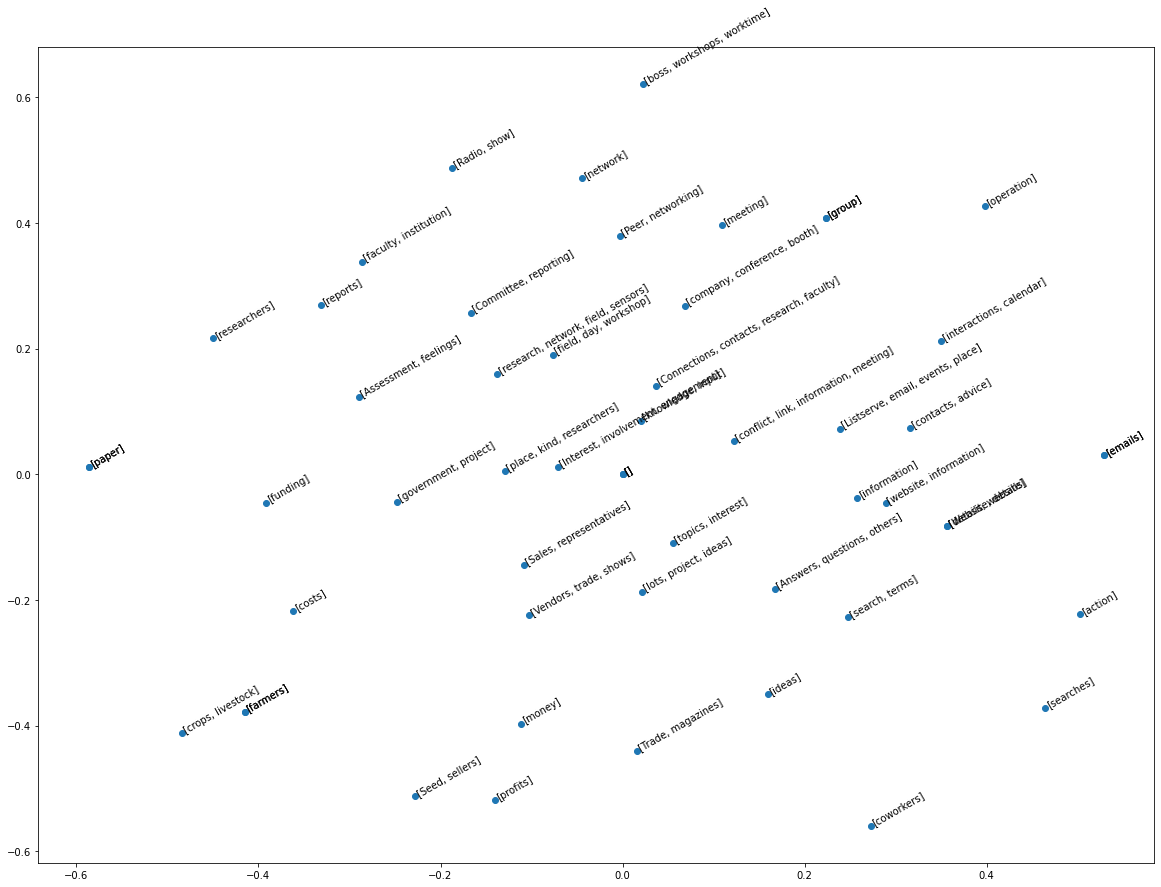

In [65]:
from sklearn.manifold import MDS 

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=3)
fitted = mds.fit_transform(dissim)
fig = plt.figure(figsize=(20, 15))

ax = fig.gca()

X = fitted[:,0]
Y = fitted[:,1]

ax.scatter(X, Y)

for index, lab in enumerate(nounSpanList): 
    ax.text(X[index], Y[index], s=str(lab), rotation=30)
    
plt.show()


In [52]:
#an attempt at writing the code using the new way of splitting when creating the document object 
import importlib
imported_module = importlib.import_module("DocumentWorking")
importlib.reload(imported_module)
from DocumentWorking import *

doc = Document("/home/blitt/Academic/PSC/NLPPipelines/AG2PIAnalytics/AG2PISlides.csv",nlp,subsetColumns=["Persona", "Touchpoint", ["Touchpoint", "Persona"]])

In [55]:
"""
Subset list is one of the lists from subsetColumns given when initializing the Document object. 
It specifies first what information we will be taking a slice of to create the tree, and 
what information will be used to color the tree. 

cleaningLevel is the level of information that we want to take. Right now we should always use "workingDoc",
since we need actual spaCy documents to get spans and calculate span similarity. 

Key is the "slice" to take. 


For example, we could have: 
key = 'How do they first discover the existence of AG2PI & what are they looking for?'
clusterSentEmbeddings(["Touchpoint", "Persona"], "workingDoc", key) 

which would take answers to the question "How do they first discover the existence of AG2PI & what are they looking for"
colored by Persona, using text from the workingDoc text created during the automatic cleaning of the data
that occurs when creating Document. 
"""

def clusterSentEmbeddings(subsetList, cleaningLevel, inKey, ax=None): 
    #example 
    #personaDict = doc.getDoubleColSubAttributeDict(["Touchpoint", "Persona"], "workingDoc")
    #inKey = 'How do they first discover the existence of AG2PI & what are they looking for?'
    
    personaDict = doc.getDoubleColSubAttributeDict(["Touchpoint", "Persona"], "workingDoc")
    
    """
    recreate the nested dictionary but get the spans instead of having the working doc
    this dictionary has touchpoints as the outer key and personas as the inner, so we can easily split by persona 
    for a particular toucpoint 
    """
    spanDict = {}
    for outerKey in personaDict.keys():
        spanDict[outerKey] = {}
        for innerKey in personaDict[outerKey].keys(): 
            spanDict[outerKey][innerKey] = getSpans(personaDict[outerKey][innerKey]) 

    #we most likely also only want to get dictionaries for one value of the touchpoint 
    keyDictSpans = spanDict[inKey]

    #now add spaces so there are technically no double spans in keyDict
    #use temporary dictionary to hold items while changing them 
    inSpans = {}

    #need to do deepcopy here
    keyDict = {}

    for key in keyDictSpans.keys(): 
        keyDict[key] = [None for item in range(0, len(keyDictSpans[key]))]
        for index, span in enumerate(keyDictSpans[key]): 
            spaceSpan = str(span)

            #add as many spaces to this span as needed so that there are no doubles, tripes
            #etc.. in our span list when we go to create plot/assign colors 
            while spaceSpan in inSpans: 
                spaceSpan += " "

            inSpans[spaceSpan] = True 

            #replace non-spaced version of span with space span 
            keyDict[key][index] = spaceSpan

    #get colors, map to keys in dictionary created above
    colorListFull = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#f781bf", "#999999"]
    colorListFull = [item.upper() for item in colorListFull]
    colorKeyMapping = dict(zip(sorted(list(keyDict.keys())), colorListFull[:len(keyDict.keys())]))

    #make sure legend order matches with colors
    legendElements = []
    for index, key in enumerate(sorted(list(keyDict.keys()))):
        currColor = colorListFull[index]
        legendElements.insert(0, Patch(facecolor=currColor,label=key))

    #map each span to the color associated with its key in keyDict
    #this way we can easily grab the color for any span when plotting 
    colorSpanMapping = {
        str(span):colorKeyMapping[key]
        for key, val in keyDict.items()
        for span in val}

    #NOTE: we should be ok matching the spans to the strings because we sort the keys when we iterate 
    #and we maintain the order of items in the lists within keyDictSpans 
    #create list of all spans 
    spanList = []
    for k in sorted(list(keyDictSpans.keys())): 
        spanList += keyDictSpans[k]

    #create list of all string versions of spans (with spaces )
    labelList = []
    for k in sorted(list(keyDict.keys())): 
        labelList += keyDict[k]
    
    simList = getNounSimList(spanList)
    simList = np.array(simList)

    #get linkage 
    linked = linkage(simList, "ward")

    #COLORING 
    #black
    defaultColor = "#000000" 

    link_cols = {}

    #go through only the first two columns of the linkage matrix (which contain linkage information)
    #enumerate gives both an index (i) and the object in our data source (a 2d row of linkage)
    for i, i12 in enumerate(linked[:,:2].astype(int)):

        #for x in i12 iterates through nodes linked in this cluster
        #gets the color of either the nodes (if leaves) or subtrees (if not leaves i.e. x > len(Z)) being linked
        c1, c2 = (link_cols[x] if x > len(linked) else colorSpanMapping[labelList[x]] for x in i12) 

        #if the colors are the same, then make merged tree of c1 and c2 (located at i + 1 + len(Z)) have same color 
        #as the subtrees. IF NOT, simply use default color 
        link_cols[i+1+len(linked)] = c1 if (c1 == c2 or i12[0] < len(linked) or i12[1] < len(linked)) else defaultColor

    #the link function is basically saying, what should I color the upside-down U part of the tree that 
    #links two subtrees 
    
    
    if ax is None: 
        ax = plt.gca()
    D = dendrogram(Z=linked, labels=labelList, orientation="left",color_threshold=None, link_color_func=lambda x: link_cols[x])
    ax.legend(handles=legendElements,loc='upper left')
    #ax.set_title(inKey)
    print(inKey)
    return ax
    

/home/blitt/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


How do they first discover the existence of AG2PI & what are they looking for?


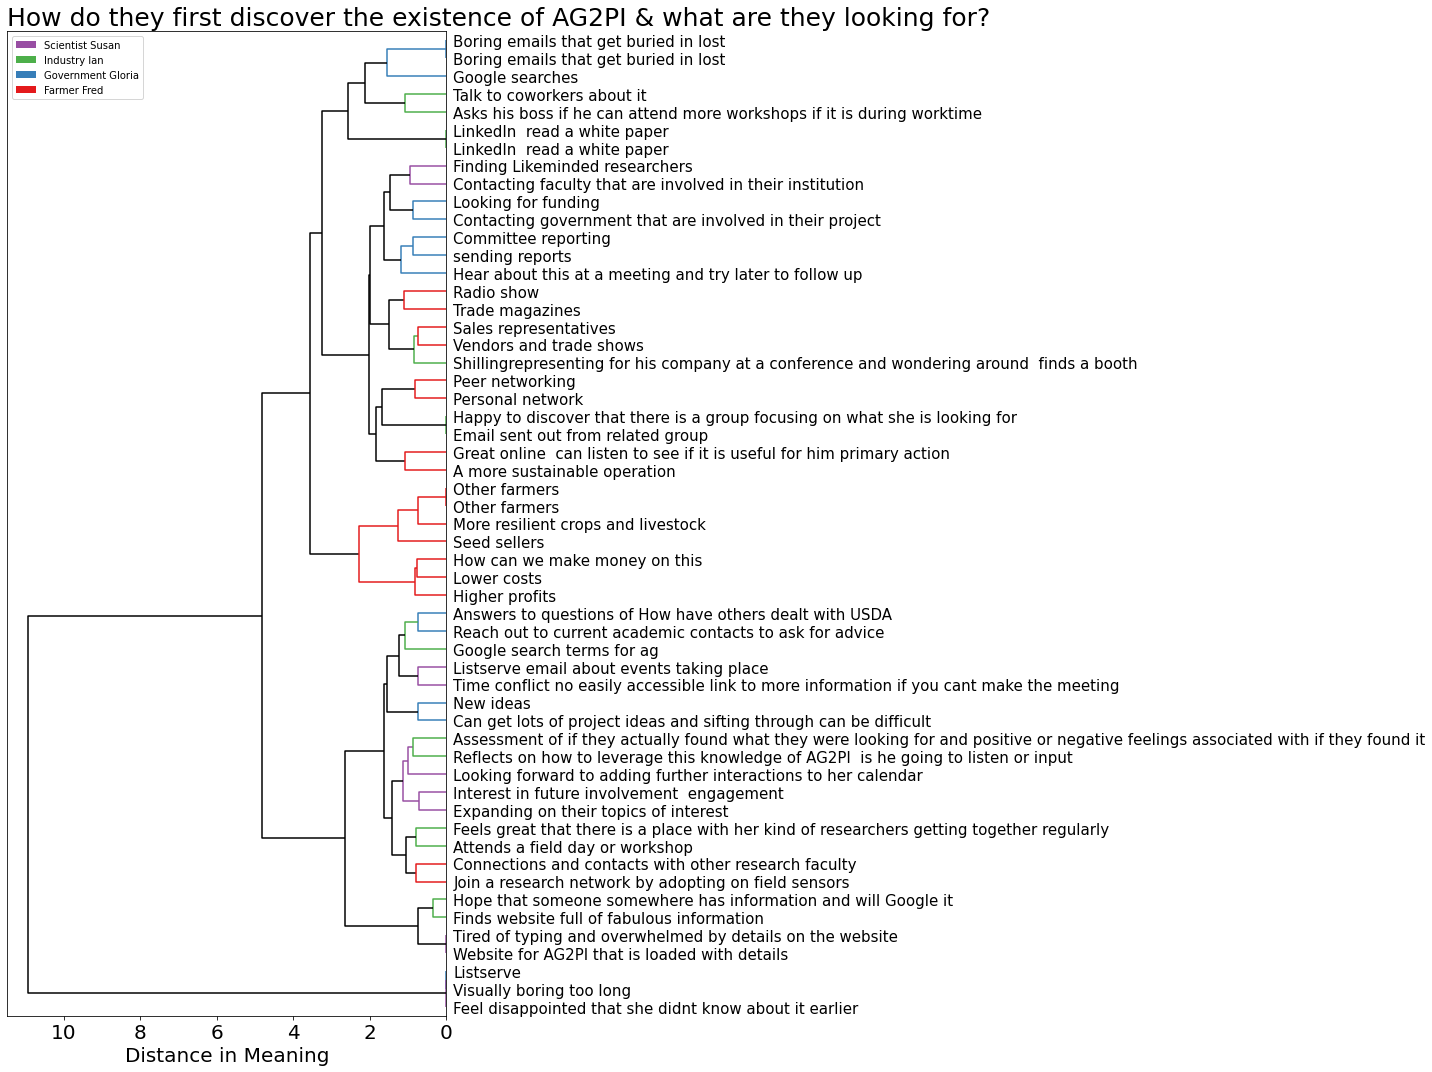

In [56]:
plt.figure(figsize=(20, 15))
ax = clusterSentEmbeddings(["Touchpoint", "Persona"], "workingDoc", 'How do they first discover the existence of AG2PI & what are they looking for?')
#D = dendrogram(Z=linked, labels=labelList, orientation="left",color_threshold=None, link_color_func=lambda x: link_cols[x])
ax.tick_params("y", labelsize=15)
ax.tick_params("x", labelsize=20)
#ax.tick_params(axis='both', which='major', labelsize=20)
#plt.rcParams["xtick.labelsize"] = 30
#plt.rcParams["ytick.labelsize"] = 20
ax.set_xlabel("Distance in Meaning", size=20)
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["axes.titlesize"] = 25
#ax.rc('legend',fontsize=15)
#ax.rc("axes", titlesize=25)
#ax.rc("")
ax.set_title('How do they first discover the existence of AG2PI & what are they looking for?', loc="left")
plt.tight_layout()
plt.savefig("/home/blitt/Academic/PSC/NLPPipelines/AG2PIAnalytics/mockups/sentEmbeddingSimilarity.jpg")